Display the NVIDIA GPU status to check if the GPU is available and being utilized.

In [45]:
!nvidia-smi

Wed Oct  9 15:36:12 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             27W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Get the current working directory and print it to verify the environment setup.

In [46]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working/yolov9


Clone the YOLOv9 repository from GitHub and change the current directory to the cloned repository. Also install the requirements

In [47]:
!git clone https://github.com/WongKinYiu/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 781, done.
remote: Total 781 (delta 0), reused 0 (delta 0), pack-reused 781 (from 1)
Receiving objects: 100% (781/781), 3.27 MiB | 29.11 MiB/s, done.
Resolving deltas: 100% (331/331), done.
/kaggle/working/yolov9/yolov9


Install the Roboflow library for accessing datasets from Roboflow.

In [48]:
!pip install -q roboflow

Download pre-trained weights for various YOLOv9 models and save them to the weights directory.

In [49]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c-seg.pt

Check if the weights are downloaded

In [50]:
!ls -la {HOME}/weights

total 456940
drwxr-xr-x  2 root root      4096 Oct  9 15:36 .
drwxr-xr-x 17 root root      4096 Oct  9 15:36 ..
-rw-r--r--  1 root root  55807471 Mar 17  2024 gelan-c-seg.pt
-rw-r--r--  1 root root  51508261 Feb 18  2024 gelan-c.pt
-rw-r--r--  1 root root 117203713 Feb 18  2024 gelan-e.pt
-rw-r--r--  1 root root 103153312 Feb 18  2024 yolov9-c.pt
-rw-r--r--  1 root root 140217688 Feb 18  2024 yolov9-e.pt


In [51]:
%cd {HOME}/yolov9

/kaggle/working/yolov9/yolov9


There are some library issues with yolov9. the solution is to download specific version of pillow


In [52]:
pip install Pillow==9.5.0

Note: you may need to restart the kernel to use updated packages.


Import the Roboflow library and authenticate using the provided API key to access a specific project and version. The below code snippet can be found when you go to the dataset that you want to download and click on download. It gives you option of code snippet

In [53]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="your_api_key")
project = rf.workspace("lamar-university-venef").project("grocery-rfn8l")
version = project.version(9)
dataset = version.download("yolov9")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to grocery-9 in yolov9:: 100%|██████████| 70772/70772 [00:12<00:00, 5760.33it/s]


The below code is necessary as we are finetuning the coco model
Write a customized YAML configuration file for a new model using the previously defined number of classes. We rewrite the classes in the custom yaml file

In [54]:
# define number of classes based on YAML
import yaml
with open("/kaggle/working/yolov9/grocery-9/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [55]:
num_classes

'62'

In [56]:
%cat /kaggle/working/yolov9/models/segment/gelan-c-seg.yaml

# YOLOv9

# parameters
nc: 80  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple
#activation: nn.LeakyReLU(0.1)
#activation: nn.ReLU()

# anchors
anchors: 3

# gelan backbone
backbone:
  [
   # conv down
   [-1, 1, Conv, [64, 3, 2]],  # 0-P1/2

   # conv down
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4

   # elan-1 block
   [-1, 1, RepNCSPELAN4, [256, 128, 64, 1]],  # 2

   # avg-conv down
   [-1, 1, ADown, [256]],  # 3-P3/8

   # elan-2 block
   [-1, 1, RepNCSPELAN4, [512, 256, 128, 1]],  # 4

   # avg-conv down
   [-1, 1, ADown, [512]],  # 5-P4/16

   # elan-2 block
   [-1, 1, RepNCSPELAN4, [512, 512, 256, 1]],  # 6

   # avg-conv down
   [-1, 1, ADown, [512]],  # 7-P5/32

   # elan-2 block
   [-1, 1, RepNCSPELAN4, [512, 512, 256, 1]],  # 8
  ]

# gelan head
head:
  [
   # elan-spp block
   [-1, 1, SPPELAN, [512, 256]],  # 9

   # up-concat merge
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # ca

In [57]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [58]:
%%writetemplate /kaggle/working/yolov9/models/segment/custom_gelan-c-seg.yaml
# YOLOv9

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple
#activation: nn.LeakyReLU(0.1)
#activation: nn.ReLU()

# anchors
anchors: 3

# gelan backbone
backbone:
  [
   # conv down
   [-1, 1, Conv, [64, 3, 2]],  # 0-P1/2

   # conv down
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4

   # elan-1 block
   [-1, 1, RepNCSPELAN4, [256, 128, 64, 1]],  # 2

   # avg-conv down
   [-1, 1, ADown, [256]],  # 3-P3/8

   # elan-2 block
   [-1, 1, RepNCSPELAN4, [512, 256, 128, 1]],  # 4

   # avg-conv down
   [-1, 1, ADown, [512]],  # 5-P4/16

   # elan-2 block
   [-1, 1, RepNCSPELAN4, [512, 512, 256, 1]],  # 6

   # avg-conv down
   [-1, 1, ADown, [512]],  # 7-P5/32

   # elan-2 block
   [-1, 1, RepNCSPELAN4, [512, 512, 256, 1]],  # 8
  ]

# gelan head
head:
  [
   # elan-spp block
   [-1, 1, SPPELAN, [512, 256]],  # 9

   # up-concat merge
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4

   # elan-2 block
   [-1, 1, RepNCSPELAN4, [512, 512, 256, 1]],  # 12

   # up-concat merge
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3

   # elan-2 block
   [-1, 1, RepNCSPELAN4, [256, 256, 128, 1]],  # 15 (P3/8-small)

   # avg-conv-down merge
   [-1, 1, ADown, [256]],
   [[-1, 12], 1, Concat, [1]],  # cat head P4

   # elan-2 block
   [-1, 1, RepNCSPELAN4, [512, 512, 256, 1]],  # 18 (P4/16-medium)

   # avg-conv-down merge
   [-1, 1, ADown, [512]],
   [[-1, 9], 1, Concat, [1]],  # cat head P5

   # elan-2 block
   [-1, 1, RepNCSPELAN4, [512, 512, 256, 1]],  # 21 (P5/32-large)

   # segment
   [[15, 18, 21], 1, Segment, [nc, 32, 256]],  # Segment(P3, P4, P5)
  ]

In [ ]:
command  to start training the model with specified parameters. More parameters can be found on the github of yolov9

In [59]:
%cd {HOME}/yolov9



!python segment/train.py \
--batch 16 --epochs 15 --img 640 --device 0,1 --close-mosaic 15 \
--data {dataset.location}/data.yaml \
--weights /kaggle/working/weights/gelan-c-seg.pt \
--cfg models/segment/custom_gelan-c-seg.yaml \
--hyp hyp.scratch-high.yaml \
--no-overlap \
--workers 8 \
--name yolov9_seg_Results --cache


Analyse the results on tensorboard

In [60]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Go to directory to check the results

In [61]:
!ls /kaggle/working/yolov9/runs/train-seg/yolov9_seg_Results

ls: cannot access '/kaggle/working/yolov9/runs/train-seg/yolov9_seg_Results': No such file or directory


In [62]:
from IPython.display import Image

Image(filename=f"/kaggle/working/yolov9/runs/train-seg/yolov9_seg_Results/results.png", width=1000)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/yolov9/runs/train-seg/yolov9_seg_Results/results.png'

In [ ]:
from IPython.display import Image

Image(filename=f"/kaggle/working/yolov9/runs/train-seg/yolov9_seg_Results/confusion_matrix.png", width=1000)

In [ ]:
from IPython.display import Image

Image(filename=f"/kaggle/working/yolov9/runs/train-seg/yolov9_seg_Results/val_batch0_pred.jpg", width=1000)

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

I had trained the model first and downloaded the weigths file. Then uploaded it as a dataset on kaggle and then given the path

In [63]:
import kagglehub
kagglehub.dataset_download('sushantrajbhar/uploded-model', path='best.pt')


'/kaggle/input/uploded-model/best.pt'

A line in predict.py has issue in yolov9. As I had cloned the repo in kaggle, the predict.py was downloaded as an output file which I cannot edit directly.Below code is written to overwrite the file with the changes. No need if you can directly do the changes in the predict.py file

masks = process_mask(proto[i], det[:, 6:], det[:, :4], im.shape[2:], upsample=True) # HWC   

changed to in predict.py

masks = process_mask(proto[2].squeeze(0), det[:, 6:], det[:, :4], im.shape[2:], upsample=True)  # HWC

In [64]:
code="""
import argparse
import os
import platform
import sys
from pathlib import Path

import torch

FILE = Path(__file__).resolve()
ROOT = FILE.parents[1]  # YOLO root directory
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative

from models.common import DetectMultiBackend
from utils.dataloaders import IMG_FORMATS, VID_FORMATS, LoadImages, LoadScreenshots, LoadStreams
from utils.general import (LOGGER, Profile, check_file, check_img_size, check_imshow, check_requirements, colorstr, cv2,
                           increment_path, non_max_suppression, print_args, scale_boxes, scale_segments,
                           strip_optimizer, xyxy2xywh)
from utils.plots import Annotator, colors, save_one_box
from utils.segment.general import masks2segments, process_mask
from utils.torch_utils import select_device, smart_inference_mode


@smart_inference_mode()
def run(
    weights=ROOT / 'yolo-seg.pt',  # model.pt path(s)
    source=ROOT / 'data/images',  # file/dir/URL/glob/screen/0(webcam)
    data=ROOT / 'data/coco.yaml',  # dataset.yaml path
    imgsz=(640, 640),  # inference size (height, width)
    conf_thres=0.25,  # confidence threshold
    iou_thres=0.45,  # NMS IOU threshold
    max_det=1000,  # maximum detections per image
    device='',  # cuda device, i.e. 0 or 0,1,2,3 or cpu
    view_img=False,  # show results
    save_txt=False,  # save results to *.txt
    save_conf=False,  # save confidences in --save-txt labels
    save_crop=False,  # save cropped prediction boxes
    nosave=False,  # do not save images/videos
    classes=None,  # filter by class: --class 0, or --class 0 2 3
    agnostic_nms=False,  # class-agnostic NMS
    augment=False,  # augmented inference
    visualize=False,  # visualize features
    update=False,  # update all models
    project=ROOT / 'runs/predict-seg',  # save results to project/name
    name='exp',  # save results to project/name
    exist_ok=False,  # existing project/name ok, do not increment
    line_thickness=3,  # bounding box thickness (pixels)
    hide_labels=False,  # hide labels
    hide_conf=False,  # hide confidences
    half=False,  # use FP16 half-precision inference
    dnn=False,  # use OpenCV DNN for ONNX inference
    vid_stride=1,  # video frame-rate stride
    retina_masks=False,
):
    source = str(source)
    save_img = not nosave and not source.endswith('.txt')  # save inference images
    is_file = Path(source).suffix[1:] in (IMG_FORMATS + VID_FORMATS)
    is_url = source.lower().startswith(('rtsp://', 'rtmp://', 'http://', 'https://'))
    webcam = source.isnumeric() or source.endswith('.txt') or (is_url and not is_file)
    screenshot = source.lower().startswith('screen')
    if is_url and is_file:
        source = check_file(source)  # download

    # Directories
    save_dir = increment_path(Path(project) / name, exist_ok=exist_ok)  # increment run
    (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

    # Load model
    device = select_device(device)
    model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)
    stride, names, pt = model.stride, model.names, model.pt
    imgsz = check_img_size(imgsz, s=stride)  # check image size

    # Dataloader
    bs = 1  # batch_size
    if webcam:
        view_img = check_imshow(warn=True)
        dataset = LoadStreams(source, img_size=imgsz, stride=stride, auto=pt, vid_stride=vid_stride)
        bs = len(dataset)
    elif screenshot:
        dataset = LoadScreenshots(source, img_size=imgsz, stride=stride, auto=pt)
    else:
        dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt, vid_stride=vid_stride)
    vid_path, vid_writer = [None] * bs, [None] * bs

    # Run inference
    model.warmup(imgsz=(1 if pt else bs, 3, *imgsz))  # warmup
    seen, windows, dt = 0, [], (Profile(), Profile(), Profile())
    for path, im, im0s, vid_cap, s in dataset:
        with dt[0]:
            im = torch.from_numpy(im).to(model.device)
            im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
            im /= 255  # 0 - 255 to 0.0 - 1.0
            if len(im.shape) == 3:
                im = im[None]  # expand for batch dim

        # Inference
        with dt[1]:
            visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if visualize else False
            pred, proto = model(im, augment=augment, visualize=visualize)[:2]

        # NMS
        with dt[2]:
            pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det, nm=32)

        # Second-stage classifier (optional)
        # pred = utils.general.apply_classifier(pred, classifier_model, im, im0s)

        # Process predictions
        for i, det in enumerate(pred):  # per image
            seen += 1
            if webcam:  # batch_size >= 1
                p, im0, frame = path[i], im0s[i].copy(), dataset.count
                s += f'{i}: '
            else:
                p, im0, frame = path, im0s.copy(), getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(save_dir / p.name)  # im.jpg
            txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # im.txt
            s += '%gx%g ' % im.shape[2:]  # print string
            imc = im0.copy() if save_crop else im0  # for save_crop
            annotator = Annotator(im0, line_width=line_thickness, example=str(names))
            if len(det):
                masks = process_mask(proto[2].squeeze(0), det[:, 6:], det[:, :4], im.shape[2:], upsample=True)  # HWC
                det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], im0.shape).round()  # rescale boxes to im0 size

                # Segments
                if save_txt:
                    segments = reversed(masks2segments(masks))
                    segments = [scale_segments(im.shape[2:], x, im0.shape, normalize=True) for x in segments]

                # Print results
                for c in det[:, 5].unique():
                    n = (det[:, 5] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # Mask plotting
                annotator.masks(masks,
                                colors=[colors(x, True) for x in det[:, 5]],
                                im_gpu=None if retina_masks else im[i])

                # Write results
                for j, (*xyxy, conf, cls) in enumerate(reversed(det[:, :6])):
                    if save_txt:  # Write to file
                        segj = segments[j].reshape(-1)  # (n,2) to (n*2)
                        line = (cls, *segj, conf) if save_conf else (cls, *segj)  # label format
                        with open(f'{txt_path}.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\\n')
                    if save_img or save_crop or view_img:  # Add bbox to image
                        c = int(cls)  # integer class
                        label = None if hide_labels else (names[c] if hide_conf else f'{names[c]} {conf:.2f}')
                        annotator.box_label(xyxy, label, color=colors(c, True))
                        # annotator.draw.polygon(segments[j], outline=colors(c, True), width=3)
                    if save_crop:
                        save_one_box(xyxy, imc, file=save_dir / 'crops' / names[c] / f'{p.stem}.jpg', BGR=True)

            # Stream results
            im0 = annotator.result()
            if view_img:
                if platform.system() == 'Linux' and p not in windows:
                    windows.append(p)
                    cv2.namedWindow(str(p), cv2.WINDOW_NORMAL | cv2.WINDOW_KEEPRATIO)  # allow window resize (Linux)
                    cv2.resizeWindow(str(p), im0.shape[1], im0.shape[0])
                cv2.imshow(str(p), im0)
                if cv2.waitKey(1) == ord('q'):  # 1 millisecond
                    exit()

            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)
                else:  # 'video' or 'stream'
                    if vid_path[i] != save_path:  # new video
                        vid_path[i] = save_path
                        if isinstance(vid_writer[i], cv2.VideoWriter):
                            vid_writer[i].release()  # release previous video writer
                        if vid_cap:  # video
                            fps = vid_cap.get(cv2.CAP_PROP_FPS)
                            w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                            h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        else:  # stream
                            fps, w, h = 30, im0.shape[1], im0.shape[0]
                        save_path = str(Path(save_path).with_suffix('.mp4'))  # force *.mp4 suffix on results videos
                        vid_writer[i] = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                    vid_writer[i].write(im0)

        # Print time (inference-only)
        LOGGER.info(f"{s}{'' if len(det) else '(no detections), '}{dt[1].dt * 1E3:.1f}ms")

    # Print results
    t = tuple(x.t / seen * 1E3 for x in dt)  # speeds per image
    LOGGER.info(f'Speed: %.1fms pre-process, %.1fms inference, %.1fms NMS per image at shape {(1, 3, *imgsz)}' % t)
    if save_txt or save_img:
        s = f"\\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
        LOGGER.info(f"Results saved to {colorstr('bold', save_dir)}{s}")
    if update:
        strip_optimizer(weights[0])  # update model (to fix SourceChangeWarning)


def parse_opt():
    parser = argparse.ArgumentParser()
    parser.add_argument('--weights', nargs='+', type=str, default=ROOT / 'yolo-seg.pt', help='model path(s)')
    parser.add_argument('--source', type=str, default=ROOT / 'data/images', help='file/dir/URL/glob/screen/0(webcam)')
    parser.add_argument('--data', type=str, default=ROOT / 'data/coco128.yaml', help='(optional) dataset.yaml path')
    parser.add_argument('--imgsz', '--img', '--img-size', nargs='+', type=int, default=[640], help='inference size h,w')
    parser.add_argument('--conf-thres', type=float, default=0.25, help='confidence threshold')
    parser.add_argument('--iou-thres', type=float, default=0.45, help='NMS IoU threshold')
    parser.add_argument('--max-det', type=int, default=1000, help='maximum detections per image')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--view-img', action='store_true', help='show results')
    parser.add_argument('--save-txt', action='store_true', help='save results to *.txt')
    parser.add_argument('--save-conf', action='store_true', help='save confidences in --save-txt labels')
    parser.add_argument('--save-crop', action='store_true', help='save cropped prediction boxes')
    parser.add_argument('--nosave', action='store_true', help='do not save images/videos')
    parser.add_argument('--classes', nargs='+', type=int, help='filter by class: --classes 0, or --classes 0 2 3')
    parser.add_argument('--agnostic-nms', action='store_true', help='class-agnostic NMS')
    parser.add_argument('--augment', action='store_true', help='augmented inference')
    parser.add_argument('--visualize', action='store_true', help='visualize features')
    parser.add_argument('--update', action='store_true', help='update all models')
    parser.add_argument('--project', default=ROOT / 'runs/predict-seg', help='save results to project/name')
    parser.add_argument('--name', default='exp', help='save results to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    parser.add_argument('--line-thickness', default=3, type=int, help='bounding box thickness (pixels)')
    parser.add_argument('--hide-labels', default=False, action='store_true', help='hide labels')
    parser.add_argument('--hide-conf', default=False, action='store_true', help='hide confidences')
    parser.add_argument('--half', action='store_true', help='use FP16 half-precision inference')
    parser.add_argument('--dnn', action='store_true', help='use OpenCV DNN for ONNX inference')
    parser.add_argument('--vid-stride', type=int, default=1, help='video frame-rate stride')
    parser.add_argument('--retina-masks', action='store_true', help='whether to plot masks in native resolution')
    opt = parser.parse_args()
    opt.imgsz *= 2 if len(opt.imgsz) == 1 else 1  # expand
    print_args(vars(opt))
    return opt


def main(opt):
    check_requirements(exclude=('tensorboard', 'thop'))
    run(**vars(opt))


if __name__ == "__main__":
    opt = parse_opt()
    main(opt)
"""

file_path = '/kaggle/working/yolov9/segment/predict.py'

# Open the file in write mode and replace its content
with open(file_path, 'w') as f:
    f.write(code)

PRediction on test dataset

In [ ]:
%cd /kaggle/working/yolov9/
!python /kaggle/working/yolov9/segment/predict.py --source /kaggle/working/yolov9/grocery-9/test/images --weights /kaggle/input/uploded-model/best.pt --img 640 --conf 0.5 

/kaggle/working/yolov9
segment/predict: weights=['/kaggle/input/uploded-model/best.pt'], source=/kaggle/working/yolov9/grocery-9/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict-seg, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, retina_masks=False
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

/kaggle/working/yolov9/models/experimental.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/ma

View the results. just change the image_index value for more images

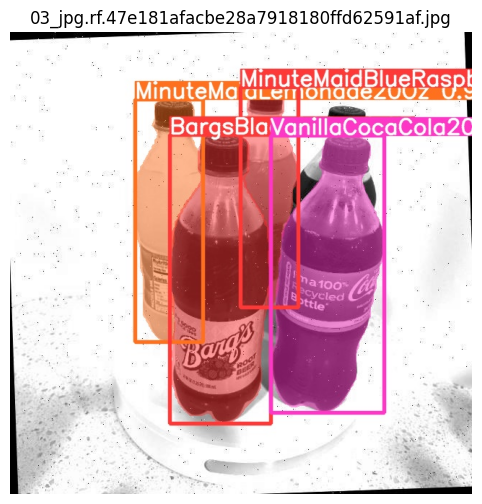

In [79]:
import os
import matplotlib.pyplot as plt
import cv2  # or PIL

# Define the path to the images folder
image_folder = '/kaggle/working/yolov9/runs/predict-seg/exp3'

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Select the index of the image you want to display
image_index = 12  # Change this index to display different images

# Make sure the index is within the range
if image_index < len(image_files):
    image_file = image_files[image_index]
    image_path = os.path.join(image_folder, image_file)

    # Read the image using OpenCV
    image = cv2.imread(image_path)
    
    # Convert BGR (OpenCV) to RGB (Matplotlib)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.title(image_file)  # Optional: display the image file name
    plt.show()
else:
    print("Image index out of range.")
